# Train VAE on CMIP data

The notebook demonstrates the process of training a Variational Autoencoder (VAE) on CMIP data. The key steps and components involved are outlined as follows:

1. The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component:
     * _Encoder_: The encoder takes a sample `x` and returns the mean `z_mean` and logarithmic variance `z_log_var` of the latent variable `z`.
    * _Latent Sampling_: The latent sampling takes `z_mean` and `z_log_var` as inputs and generates a random latent sample `z`.
    * _Decoder_: The decoder reconstructs the input `x` by taking the latent sample `z` and producing the decoded output `y`. The decoding is done backward in time, maintaining the input order.
   * _Decoder for Prediction_: The second decoder also takes the latent sample `z` but generates a forward-time prediction output.

2. The full model is created by combining the four components. Model weights and training metrics are saved in a log directory (`LOG_DIR`). If the initial epoch (`INITIAL_EPOCH`) is greater than zero, the training continues from the saved weights; otherwise, a new training session starts.

3. The data used in training includes CMIP data from the Climate Explorer. The dataset can be optionally split into training and validation sets.

4. During training, generators are prepared for training and validation on CMIP data. A beta scheduler is used to scale the KL loss during training. Callbacks are set up to save model weights and metrics.  These callbacks enable tracking the progress of the training and provide checkpoints for the model.

## Requirements

1. The notebook requires the VAE package to be installed, which is available at:

    https://github.com/andr-groth/VAE-project

2. Sample data used in the notebook is included in the `data/` folder. The data was collected with the help of the Climate Explorer at:

    http://climexp.knmi.nl

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import itertools
import os
import random
from datetime import datetime
from types import SimpleNamespace

import numpy as np
import tensorflow.keras as ks
import tensorflow.keras.backend as K
import yaml
from matplotlib import pyplot as plt
from matplotlib import ticker
from pytz import timezone
from tqdm.keras import TqdmCallback

In [3]:
from tensorflow import get_logger
from tensorflow.compat.v1 import disable_eager_execution, disable_v2_behavior

get_logger().setLevel('ERROR')
disable_eager_execution()
disable_v2_behavior()

In [4]:
from VAE import generators, models
from VAE.callbacks import Evaluate, ModelCheckpoint
from VAE.utils import beta_schedulers, collection, fileio

In [5]:
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 75
np.set_printoptions(formatter={'float_kind': lambda x: f'{x: .3f}'}, linewidth=120)

## Log directory

In the folder `LOG_DIR`, the model weights and training metrics are saved. The metrics can be monitored with Tensorboard.

In [6]:
INITIAL_EPOCH = 0
LOG_DIR = r'logs'

Setting `INITIAL_EPOCH` to a value greater than zero will continue the training in `LOG_DIR`. Otherwise, a new training is started in a new subfolder created in `LOG_DIR`.

In [7]:
INITIAL_EPOCH = 15
LOG_DIR = os.path.join(LOG_DIR, '2022-10-28T19.45')

In [8]:
if INITIAL_EPOCH == 0:
    tz = timezone('Europe/Berlin')
    log_dir = os.path.join(LOG_DIR, datetime.now(tz).strftime('%Y-%m-%dT%H.%M'))
    os.makedirs(log_dir)
    print('Start training in', os.path.normpath(log_dir))
else:
    log_dir = LOG_DIR
    assert os.path.exists(log_dir), 'Path not found'
    print('Continue training in', os.path.normpath(log_dir))

Continue training in logs\2022-10-28T19.45


## Parameters

First we specify the parameters of the model and the training.

In [9]:
if INITIAL_EPOCH == 0:
    input_shape = [16, 1 + 20]
    prediction_shape = [24, 1]
    epochs = 15
    ensemble_size = 38
    repeat_samples = 5
    params = {
        'model': {
            'activation': 'swish',
            'beta': 'beta',
            'cond_size': [12, ensemble_size],
            'cond_units': 12,
            'cond_ens_size': 6,
            'cond_use_scale': False,
            'delta': 1,
            'encoder_blocks': 3,
            'fc_units': 48,
            'fc_activation': 'tanh',
            'film_temporal': True,
            'filters': 20,
            'gamma': 3,
            'input_shape': input_shape,
            'latent_dim': 14,
            'learning_rate': 1e-3,
            'loss_weights': {
                'decoder': 1,
                'prediction': 3
            },
            'pooling': None,
            'prediction_shape': prediction_shape,
            'padding_blocks': 1,
            'repeat_samples': repeat_samples,
            'residual_units': 1,
            'set_size': 1,
            '__version__': models.__version__,
        },
        'prediction': {
            'filters': 8,
        },
        'data': {
            'filename': [
                'data/rcp45/nino34/*one*.txt',
                'data/rcp45/pcs_55S60N_5dgr_1865-2005/*one*.txt',
            ],
            'pc_scale': 5,
            'time_interval': ['1865-01-01', '2005-12-31'],
        },
        'data2': {
            'filename': [
                'data/obs/nino34/*ersst*.txt',
                'data/obs/prj/rcp45_55S60N_5dgr_1865-2005/*ersst*.txt',
            ],
            'time_interval': ['1865-01-01', '2021-12-31'],
        },
        'beta_scheduler': {
            'class_name': 'LogisticGrowth',
            'config': {
                'upper': 0.2,
                'midpoint': 5,
                'rate': 1,
            }
        },
        'fit_generator': {
            'input_length': input_shape[0],
            'prediction_length': prediction_shape[0],
            'batch_size': 128,
            'ensemble_size': ensemble_size,
            'ensemble_type': 'index',
            'filter_length': [0, 1],
            'prediction_channels': [0, prediction_shape[1]],
            'repeat_samples': repeat_samples,
            'shuffle': True,
            'strides': 1,
            'tp_period': 12,
            'validation_split': 1,
            'validation_seed': 1,
            'dtype': 'float32',
            '__version__': generators.__version__,
        },
        'fit_generator2': {
            'batch_size': 32,
            'ensemble_sync': True,
            'ensemble_type': 'random',
            'initial_epoch': epochs,
            'validation_split': '1980-09-01',
        },
        'model_fit': {
            'epochs': epochs
        },
    }

    fn = os.path.join(log_dir, 'trainer_config.yaml')
    with open(fn, 'w') as f:
        yaml.dump(params, f)

else:
    fn = os.path.join(log_dir, 'trainer_config.yaml')
    with open(fn, 'r') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

    assert params['model'].get('__version__') == models.__version__, 'Model version mismatch'
    assert params['fit_generator'].get('__version__') == generators.__version__, 'Generator version mismatch'

    params['fit_generator']['initial_epoch'] = INITIAL_EPOCH
    params.setdefault('prediction', {})

params = SimpleNamespace(**params)
# print(yaml.dump(params.__dict__))

## Model

The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component.

### Encoder

The encoder takes a sample `x` and returns `z_mean` and `z_log_var`:

In [10]:
encoder = models.Encoder(**params.model, name='encoder')

### Latent sampling

The latent sampling takes the two inputs `z_mean` and `z_log_var` and returns a set of `set_size=1` random latent sample `z`:

In [11]:
latent_sampling = models.LatentSampling(**params.model, name='latent')

### Decoder

The decoder, finally, takes a latent sample `z` and returns the decoded output `y` to reconstruct `x`. The decoding works backward in time and we set `output_reverse=True` so that the order of decoder output matches the input to the encoder.

In [12]:
decoder = models.Decoder(output_shape=params.model.get('input_shape'),
                         decoder_blocks=params.model.get('encoder_blocks'),
                         output_reverse=True,
                         **params.model,
                         name='decoder')

### Decoder for prediction

Like the decoder, the second decoder takes the same latent sample `z` and it's output will provide the prediction. In contrast to the `decoder`, we set `output_reverse=False` so that the output of `prediction` is forward in time.

In [13]:
prediction = models.Decoder(output_shape=params.model.get('prediction_shape'),
                            decoder_blocks=params.model.get('encoder_blocks'),
                            output_reverse=False,
                            **{
                                **params.model,
                                **params.prediction
                            },
                            name='prediction')

### Full model

Now that we have the four components, we a ready to create the full model.

In [14]:
model = models.VAEp(encoder, decoder, latent_sampling, prediction, **params.model)

Let's plot the model

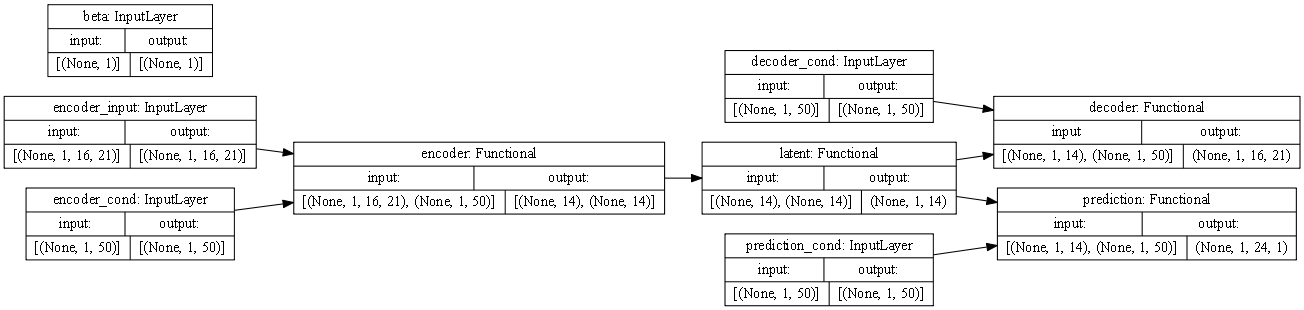

In [15]:
ks.utils.plot_model(model, show_shapes=True, dpi=75, rankdir='LR')

Summary of the model

In [16]:
model.summary(line_length=120)

Model: "mVAEp"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
encoder_input (InputLayer)             [(None, 1, 16, 21)]        0                                                     
________________________________________________________________________________________________________________________
encoder_cond (InputLayer)              [(None, 1, 50)]            0                                                     
________________________________________________________________________________________________________________________
encoder (Functional)                   [(None, 14), (None, 14)]   61606         encoder_input[0][0]                     
                                                                                encoder_cond[0][0]                      
_________________

### Load model weights (optional)

Optionally, we load model weights if `INITIAL_EPOCH > 0` to continue the training.

In [17]:
if INITIAL_EPOCH > 0:
    epoch = min(INITIAL_EPOCH, params.model_fit['epochs'])
    model_file = os.path.join(log_dir, 'model.{epoch:02d}.h5'.format(epoch=epoch))
    model.load_weights(model_file, by_name=True)
    print('Load model weights from:', os.path.normpath(model_file))

Load model weights from: logs\2022-10-28T19.45\model.15.h5


## Data

In the following, we load the data.

### CMIP data

In [18]:
pc_scale = params.data.pop('pc_scale', 1)
dataframe, metadata = fileio.read_climexp_raw_data_multi(**params.data, join='inner', dtype='float32')
time = dataframe.index.to_numpy()
titles = [metadata[key].get('description') for key in dataframe.columns.levels[0]]

We stack the data of the different files along the last axis, the channels. We restrict the number of data channels to the number of input channels of the model.

In [19]:
data = np.stack([dataframe[name].T for name in dataframe.columns.levels[0]], axis=-1)
data = data[..., :params.model['input_shape'][-1]]
print('data shape (runs, time, channels) :', data.shape)

data shape (runs, time, channels) : (38, 1692, 21)


We normalize the PCs so that their total variance matches that of the ENSO index (assumed to be the leading channel).

In [20]:
pc_idx = [title.startswith('PC') for title in titles]
pc_idx = np.array(pc_idx)[:params.model['input_shape'][-1]]
print('data is PC: ', pc_idx)

data is PC:  [False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [21]:
if np.any(pc_idx):
    data_var = np.var(data, axis=(0, 1))
    pc_scales = (data_var[0] / data_var[pc_idx] / sum(pc_idx))**0.5
    pc_scales *= pc_scale**0.5

    data[..., pc_idx] *= pc_scales
    print(f'PC scale: {pc_scales}')

PC scale: [ 5.659  9.483  19.491  23.611  18.818  29.054  31.534  24.295  45.947  24.783  17.199  29.809  44.323  54.509  33.797
  42.890  34.887  39.952  40.214  45.211]


Mean and variance of the CMIP data.

In [22]:
axis = (0, 1)
print(f'Mean     : {np.mean(data, axis=axis)} ={np.mean(data): .3f}')
print(f'Variance : {np.var(data, axis=axis)} ={np.var(data): .3f}')

Mean     : [ 0.000  0.000 -0.000 -0.000 -0.000  0.000  0.000 -0.000 -0.000 -0.000  0.000 -0.000 -0.000  0.000  0.000  0.000 -0.000
 -0.000 -0.000 -0.000 -0.000] = 0.000
Variance : [ 0.752  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188  0.188
  0.188  0.188  0.188  0.188] = 0.215


We split the CMIP5 ensemble runs into separate datasets and shuffle the different runs.

In [23]:
dataset = np.split(data, len(data), axis=0)
random.seed(params.fit_generator.get('validation_seed', None))
random.shuffle(dataset)

print('Shape of datasets  :', dataset[0].shape)
print('Number of datasets :', len(dataset))

Shape of datasets  : (1, 1692, 21)
Number of datasets : 38


We split the datasets into a set for training and a set for validation.

In [24]:
validation_split = int(len(dataset) * params.fit_generator['validation_split'])
print('Number of training datasets   :', validation_split)
print('Number of validation datasets :', len(dataset) - validation_split)

Number of training datasets   : 38
Number of validation datasets : 0


## Model training

### Prepare generators

#### Beta schedulers

For the model training, we first need a scheduler for the beta values in each epoch that scales the KL loss. We choose here an annealing scheme for the KL loss.

In [25]:
beta_scheduler = getattr(beta_schedulers,
                         params.beta_scheduler.get('class_name'))(**params.beta_scheduler.get('config'),
                                                                  dtype=data.dtype)
beta_scheduler.summary()

Summary of "LogisticGrowth" (BetaScheduler)
  dtype    : float32
  lower    : 0.0
  upper    : 0.2
  midpoint : 5
  rate     : 1


#### Fit generator

For each subset of the CMIP datasets, we create a generator. The model is trained with the first subset of the CMIP dataset.

In [26]:
month = time.astype('datetime64[M]').astype(int)
fit_gen = generators.FitGenerator(dataset[:validation_split],
                                  **params.fit_generator,
                                  beta_scheduler=beta_scheduler,
                                  time=month)
fit_gen.summary()

Number of datasets : 38
Total data size    : 1,350,216
Total data length  : 64,296
Strides            : 1
Number of samples  : 62,814
Batch size         : 128
Number of batches  : 491
Sample repetitions : 5
Actual batch size  : 128 * 5 = 640
Shuffle            : True
Filter length
  input      : 0
  prediction : 1
Ensemble condition
  size : 38
  type : index
Input channels     : all
Predicted channels : (0,)
Output shapes
  inputs
    encoder_input    : (640, 1, 16, 21)
    encoder_cond     : (640, 1, 50)
    decoder_cond     : (640, 1, 50)
    prediction_cond  : (640, 1, 50)
    beta             : (640, 1)
  targets
    decoder          : (640, 1, 16, 21)
    prediction       : (640, 1, 24, 1)


#### Validation generator (optional)

A second generator takes the second set of CMIP data. The generator is used to evaluate the sucess of the training to generalize to independent CMIP runs.

In [27]:
val_dataset = dataset[validation_split:]
if val_dataset:
    val_gen = generators.FitGenerator(val_dataset, **params.fit_generator, beta_scheduler=beta_scheduler, time=month)
    val_gen.summary()
else:
    val_gen = None
    print('No validation dataset.')

No validation dataset.


### Prepare callbacks

The callbacks are used to save the model weights and evaluation metrics in the `LOG_DIR`. The progress of the training can be monitored with Tensorboard.

In [28]:
callbacks = [
    ModelCheckpoint(filepath=os.path.join(log_dir, 'model.{epoch:02d}.h5'),
                    period=5,
                    save_best_only=False,
                    save_weights_only=True),
    ks.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=False),
]

### Fit model

Finally, we start the training of the model.

In [29]:
hist = model.fit(fit_gen,
                 validation_data=val_gen,
                 initial_epoch=INITIAL_EPOCH,
                 **params.model_fit,
                 callbacks=callbacks + [TqdmCallback(verbose=1)],
                 verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]